In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import glob

In [2]:
train_data_full , train_ma_full= [],[]
test_data_full , test_ma_full= [],[]

files = glob.glob("/content/drive/MyDrive/AI_FYP/*1h.csv")

train_data_full , train_ma_full= [],[]
test_data_full , test_ma_full= [],[]
for f in files:
  data_df = pd.read_csv(f)

  data_df = data_df[["close"]]

  data = data_df.pct_change().dropna()

  l = data.shape[0]
  idx = int(l*0.8)
  train_data= data[:idx]
  test_data = data[idx:]

  # tmp_train = train_data
  # for i in range(99):
  #   tmp_train = np.hstack((tmp_train,train_data))

  train_data_sli = np.lib.stride_tricks.sliding_window_view(train_data,(168+1,train_data.shape[1])).squeeze().astype(np.float32)

  # tmp_test = test_data
  # for i in range(99):
  #   tmp_test = np.hstack((tmp_test,test_data))

  test_data_sli = np.lib.stride_tricks.sliding_window_view(test_data,(168+1,test_data.shape[1])).squeeze().astype(np.float32)

  train_data_full.append(train_data_sli)

  test_data_full.append(test_data_sli)

In [3]:
train_data_full=np.concatenate(train_data_full)
test_data_full=np.concatenate(test_data_full)

In [4]:
train_data_full.shape

(51425, 169)

In [5]:
train_x,train_y = train_data_full[:,:-1],train_data_full[:,-1]
test_x,test_y = test_data_full[:,:-1],test_data_full[:,-1]

In [6]:
train_x.shape

(51425, 168)

In [38]:
class ClassDataset(Dataset):
    def __init__(self, input,output,threshold):
          self.input = torch.tensor(input)

          label = []
          for num in output:
            # row = [0,0,0]
            row = [0,0]
            if num>threshold:
              row[1]=1
            elif num<-threshold:
              row[0]=1
            else:
              pass
              # row[1]=1
            label.append(row)
          label = np.array(label).astype(np.float32)
          self.label = torch.tensor(label)
          self.output = torch.tensor(output)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx].T
        y = self.label[idx]

        return x,y

class Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.conv = nn.Conv1d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
    self.norm = nn.BatchNorm1d(out_channels)
    self.act = nn.LeakyReLU(True)
  
  def forward(self,x):
    y = self.conv(x)
    y = self.norm(y)
    y = self.act(y)
    return y


class Classifier(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.Conv = Conv(168,25,kernel_size=1,stride=1,padding=0)
        # self.model = nn.Sequential(
        #     nn.Linear(168,120),
        #     nn.BatchNorm1d(120),
        #     nn.LeakyReLU(True),
        #     nn.Linear(120,64),
        #     nn.BatchNorm1d(64),
        #     nn.LeakyReLU(True),
        #     nn.Linear(64,16),
        #     nn.LeakyReLU(True),
        #     nn.Linear(16,2),
        # )

    def forward(self,x):
      # x = self.model(x)
      self.Conv(x)
      return x

In [34]:
train_set = ClassDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y,0)
test_set = ClassDataset(test_x.reshape(test_x.shape[0],test_x.shape[1],1),test_y,0)

BATCH_SIZE = 1024
train_loader = DataLoader(train_set,batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE)

In [35]:
for x,l in train_set:
  print(x.shape)
  break

torch.Size([168, 1])


In [10]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
    _, lab = torch.max(y_test,dim=1)   
    
    correct_pred = (y_pred_tags == lab).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc,y_pred_tags

In [39]:
epochs = 50
lr = 0.0001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

model = Classifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [40]:
for epoch in range(20)[:1]:  # loop over the dataset multiple times

    total_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        print(inputs.size())
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    if epoch % 1 ==0:
      print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss)
      with torch.no_grad():
        model.eval()
        test_acc = 0
        for inputs,labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)

          acc ,pred_tag= multi_acc(outputs, labels)
          test_acc += acc.item()
        test_acc = test_acc/len(test_loader)
      print('[{}/{}] Test Accuracy:'.format(epoch+1, epochs), test_acc)
    

print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss)

torch.Size([1024, 168, 1])


RuntimeError: ignored

In [ ]:
with torch.no_grad():
  model.eval()
  test_acc = 0
  prediction = []
  for inputs,labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    acc,pred_tag = multi_acc(outputs, labels)
    prediction.append(pred_tag.detach().cpu().numpy())
    test_acc += acc.item()
  test_acc = test_acc/len(test_loader)

In [ ]:
signal=np.concatenate(prediction,axis=0)

In [ ]:
signal

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
ret = test_loader.dataset.output.detach().cpu().numpy()

In [ ]:
exp_return = []
for i in range(len(signal)):
  if signal[i]==2:
    exp_return.append(signal[i]*ret[i])
  elif signal[i]==0:
    exp_return.append(signal[i]*ret[i])
exp_return = np.array(exp_return)

In [ ]:
np.mean(exp_return)/np.std(exp_return)

<ipython-input-90-123f4ec5a9db>:1: RuntimeWarning: invalid value encountered in double_scalars
  np.mean(exp_return)/np.std(exp_return)


nan

In [ ]:
np.sum(exp_return)

0.0

In [ ]:
files = glob.glob("/content/drive/MyDrive/AI_FYP/*1h.csv")

In [ ]:
files[1]

'/content/drive/MyDrive/AI_FYP/BNBUSDT_1h.csv'

In [ ]:
all_signal = []
signal_return = []
b_h_return = []
all_acc = []
for f in files:
  data_df = pd.read_csv(f)

  data_df = data_df[["close"]]

  data = data_df.pct_change().dropna()

  l = data.shape[0]
  idx = int(l*0.8)
  train_data= data[:idx]
  test_data = data[idx:]

  test_data_sli = np.lib.stride_tricks.sliding_window_view(test_data,(168+1,test_data.shape[1])).squeeze().astype(np.float32)
  test_x,test_y = test_data_sli[:,:-1],test_data_sli[:,-1]

  test_set = ClassDataset(test_x,test_y,0)

  BATCH_SIZE = 256
  test_loader = DataLoader(test_set,batch_size=BATCH_SIZE)

  with torch.no_grad():
    model.eval()
    test_acc = 0
    prediction = []
    for inputs,labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      acc,pred_tag = multi_acc(outputs, labels)
      prediction.append(pred_tag.detach().cpu().numpy())
      test_acc += acc.item()
    test_acc = test_acc/len(test_loader)

  signal=np.concatenate(prediction,axis=0)
  ret = test_loader.dataset.output.detach().cpu().numpy()

  exp_return = []
  for i in range(len(signal)):
    if signal[i]==2:
      exp_return.append(-1*ret[i])
    elif signal[i]==0:
      exp_return.append(1*ret[i])
    else:
      exp_return.append(0)
  exp_return = np.array(exp_return)

  all_signal.append(signal)
  signal_return.append(exp_return)
  b_h_return.append(ret)
  all_acc.append(test_acc)

In [ ]:
for i in range(len(signal_return)):
  print(np.sum(signal_return[i]))
  print(np.sum(b_h_return[i]))

-0.7898826748278225
-0.4476132
-0.2227823060384253
-0.48859018
-0.5356791165754657
-0.85154694
-0.5248622504004743
-0.6402638
-0.34001279075346247
-0.66101265


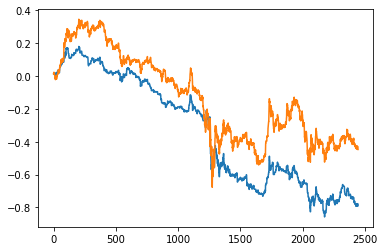

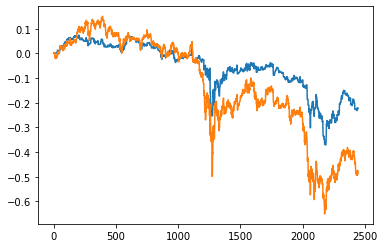

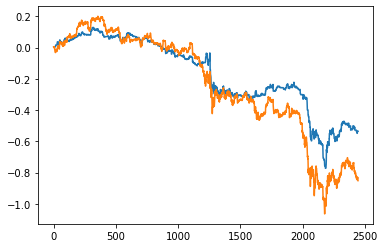

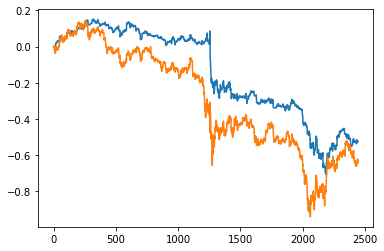

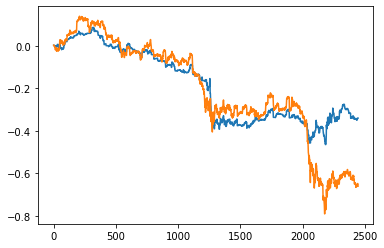

In [ ]:
for i in range(len(signal_return)):
  count = np.arange(len(signal_return[i]))
  plt.plot(count,np.cumsum(signal_return[i]))
  plt.plot(count,np.cumsum(b_h_return[i]))
  plt.show()
  # print(np.sum(signal_return[i]))
  # print(np.sum(b_h_return[i]))

In [ ]:
all_acc

In [ ]:
sig_ret = np.vstack(signal_return)

In [ ]:
b_h_ret = np.vstack(b_h_return)

In [ ]:
all_sig = np.vstack(all_signal)

In [ ]:
all_sig.shape

In [ ]:
np.save("/content/drive/MyDrive/AI_FYP/MLP_return_data/signal_return.npy",sig_ret)
np.save("/content/drive/MyDrive/AI_FYP/MLP_return_data/buy_hold_return.npy",b_h_ret)
np.save("/content/drive/MyDrive/AI_FYP/MLP_return_data/signal.npy",all_sig)
np.save("/content/drive/MyDrive/AI_FYP/MLP_return_data/acc.npy",np.array(all_acc))

In [ ]:
np.load("/content/drive/MyDrive/AI_FYP/MLP_return_data/acc.npy")